## Import all useful libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
# for interactive plots
%matplotlib notebook
plt.style.use('ggplot')

## 1. Read from data file 

In [17]:
df = pd.read_csv('NY_FL_flight_demand.csv')

## 2. Data Summary

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 694917 entries, 0 to 694916
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   search_date          694917 non-null  object
 1   origin_airport_code  694917 non-null  object
 2   origin_city          694917 non-null  object
 3   origin_region        694917 non-null  object
 4   origin_country       694917 non-null  object
 5   dest_airport_code    694917 non-null  object
 6   destination_city     694917 non-null  object
 7   destination_region   694917 non-null  object
 8   destination_country  694917 non-null  object
 9   flight_demand        694917 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 53.0+ MB


In [7]:
"""
Pandas has parsed 'search_date' column as string not datetime, lets remedy that
"""
print("Default dtype: ",type(df['search_date'][0]))
print("Modified dtype: ",type(pd.to_datetime(df['search_date'][0])))



Default dtype:  <class 'str'>
Modified dtype:  <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [39]:
"""
Converting to datetime will be useful for further operations
# """
df['search_date'] = pd.to_datetime(df['search_date'])
print("Start Date: {0} \nEnd Date: {1}".format(df['search_date'].min(),df['search_date'].max()))

"""
Setting 'search_date' as index will yield great operational benefits
"""
df.set_index('search_date', drop=True, inplace=True)

In [8]:
"""
Lets analyze the entropy of each column 
Observations: 
1. All flights are domestic
2. Some cities (likely large) have more than one airport
"""
print("Flights originating from {}".format(pd.unique(df['origin_region'])))
print("Flights destined for {}".format(pd.unique(df['destination_region'])))

Flights originating from ['FL' 'NY']
Flights destined for ['CO' 'MA' 'NY' 'DC' 'NC' 'MI' 'MD' 'AZ' 'WA' 'CA' 'TX' 'IL' 'MN' 'PA'
 'NV' 'NJ' 'OH' 'GA' 'LA' 'TN' 'FL' 'HI']


## 3. Ascertaining patterns i.e. Temporal | Spatial

In [40]:
"""
Quick operation to create some dated categorical variables
"""
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['Year'] = df.index.year
df.reset_index(inplace=True,drop=True)

<IPython.core.display.Javascript object>


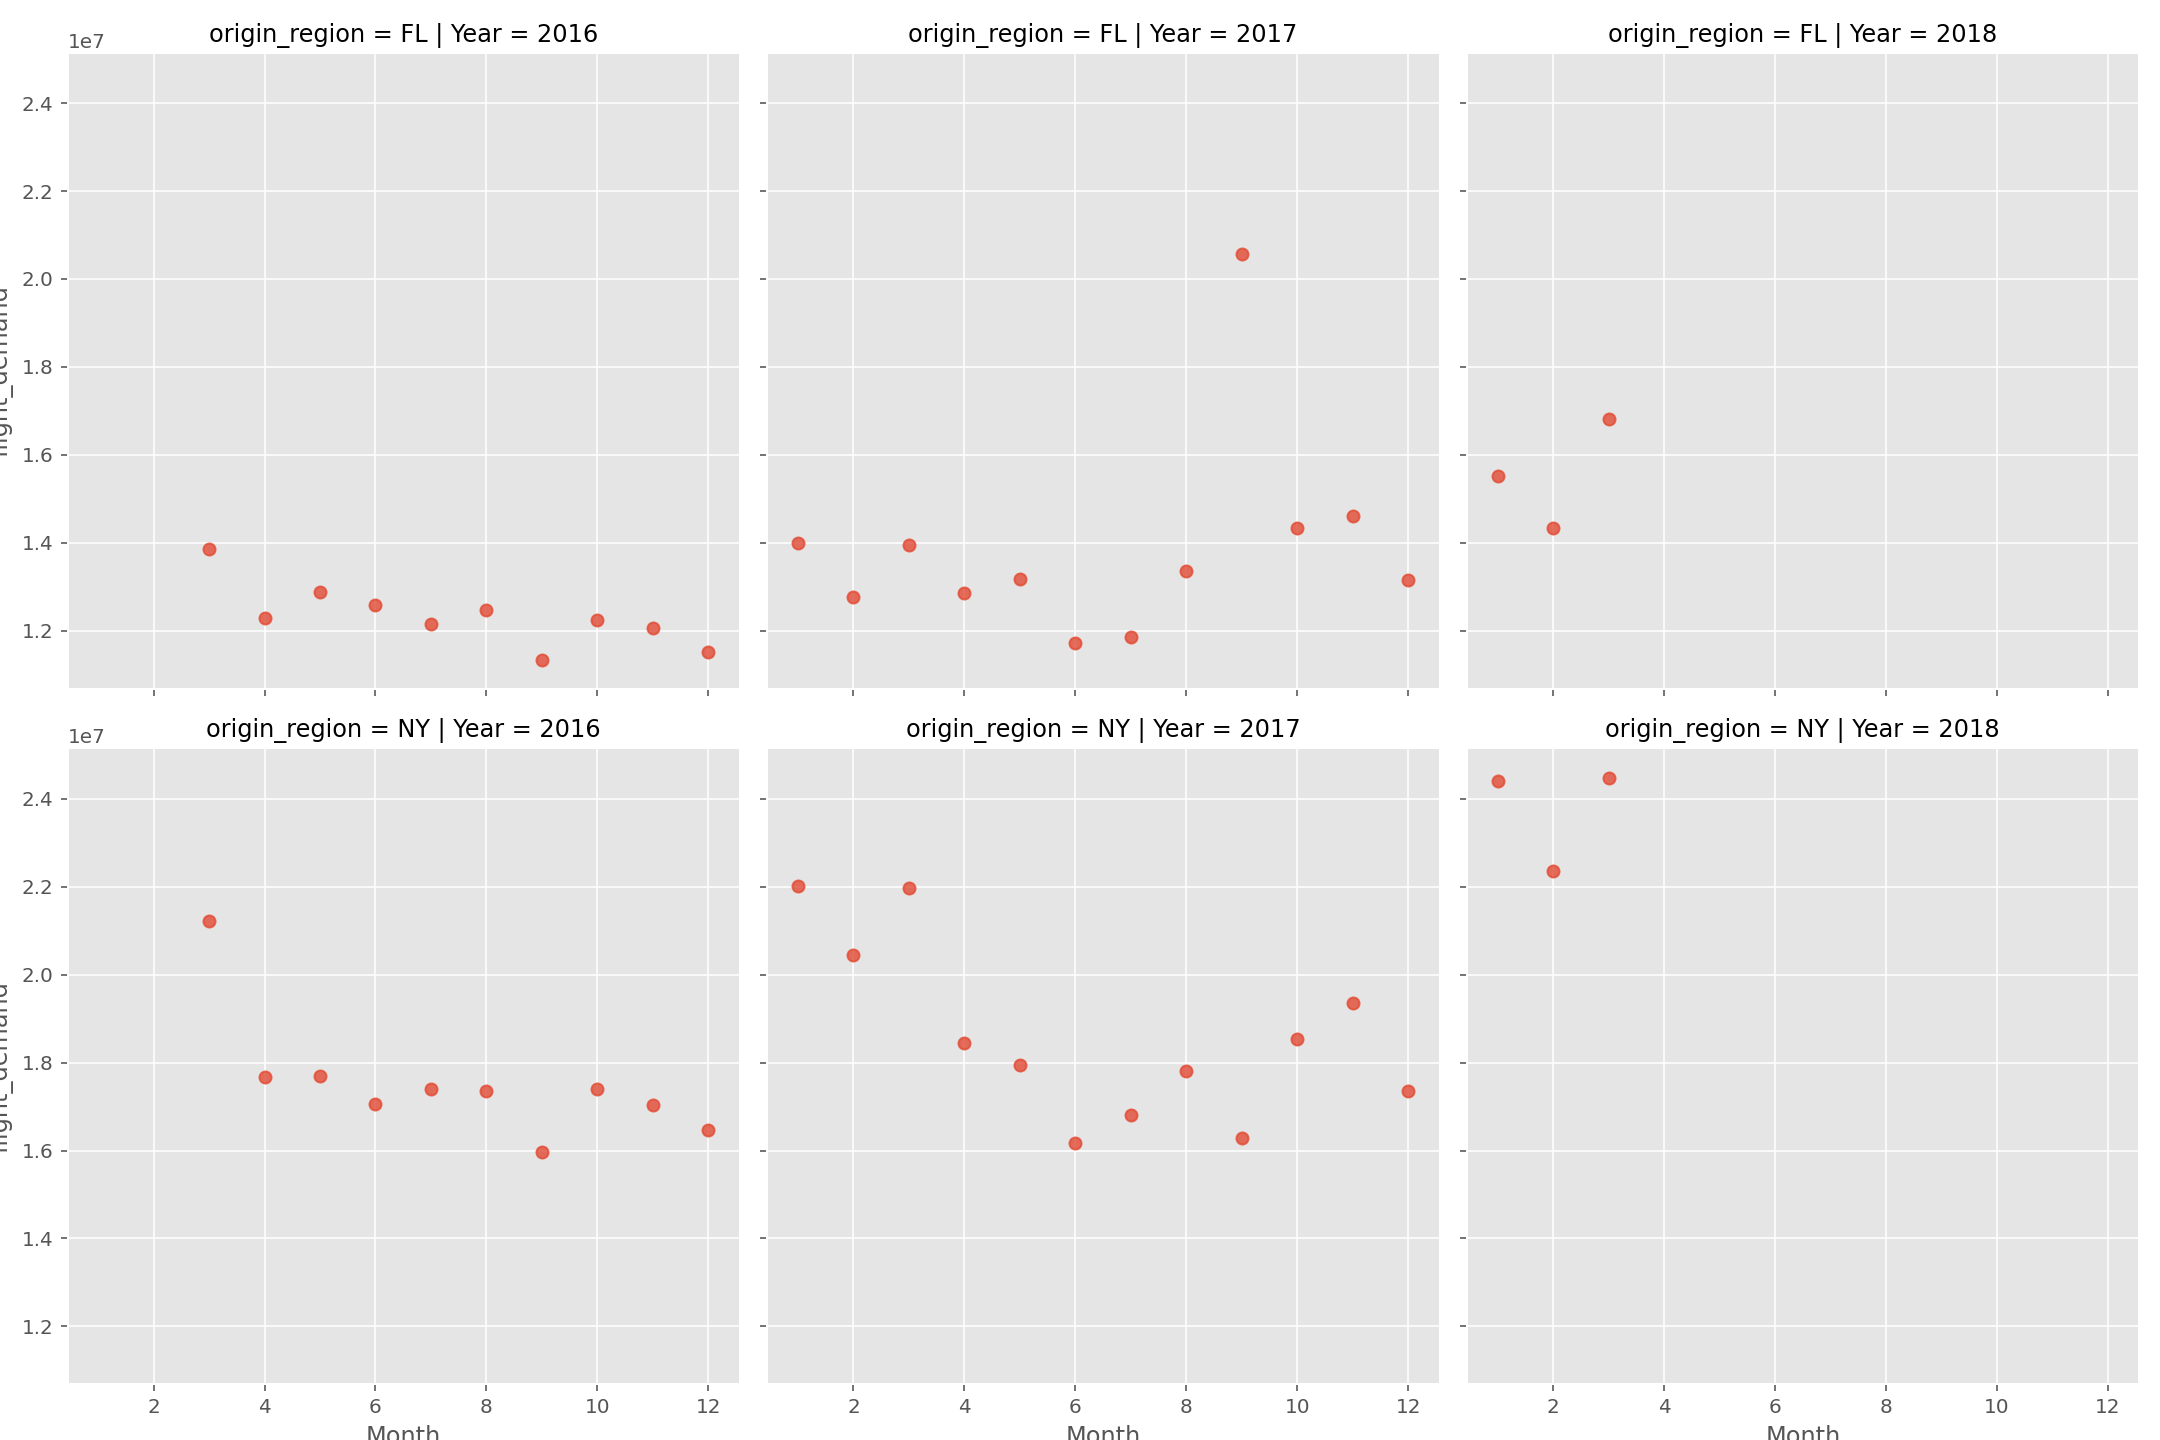

In [11]:
sns.lmplot(data=df.groupby(['origin_region','Year','Month']).sum().reset_index(),
           col='Year',row='origin_region',x='Month',y='flight_demand', fit_reg=False)
plt.show()

### Finding popular destinations 

<IPython.core.display.Javascript object>


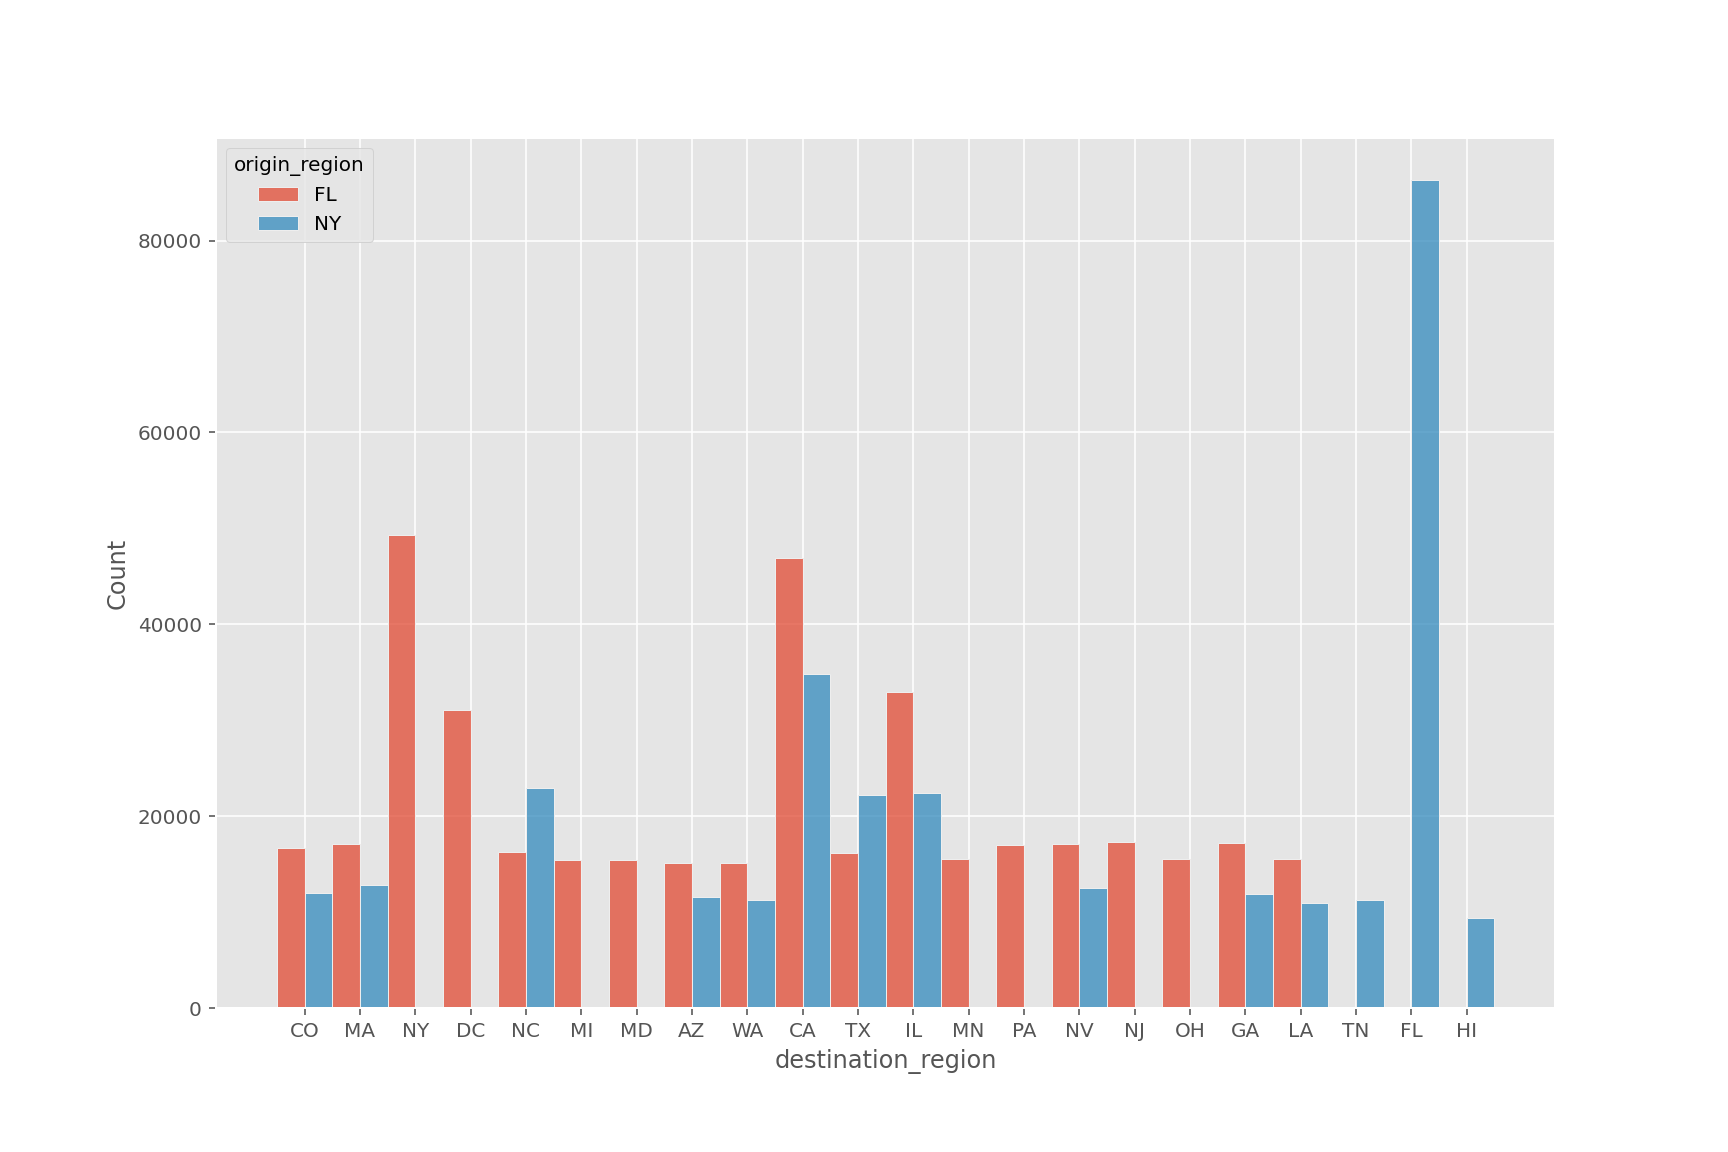

In [56]:
plt.figure(figsize=(12,8))
sns.histplot(data = df,
             hue = 'origin_region', x = 'destination_region',
             multiple='dodge')
plt.show()

New York to Florida seems to be the most popular

###  Looking at destinations across the years

<IPython.core.display.Javascript object>


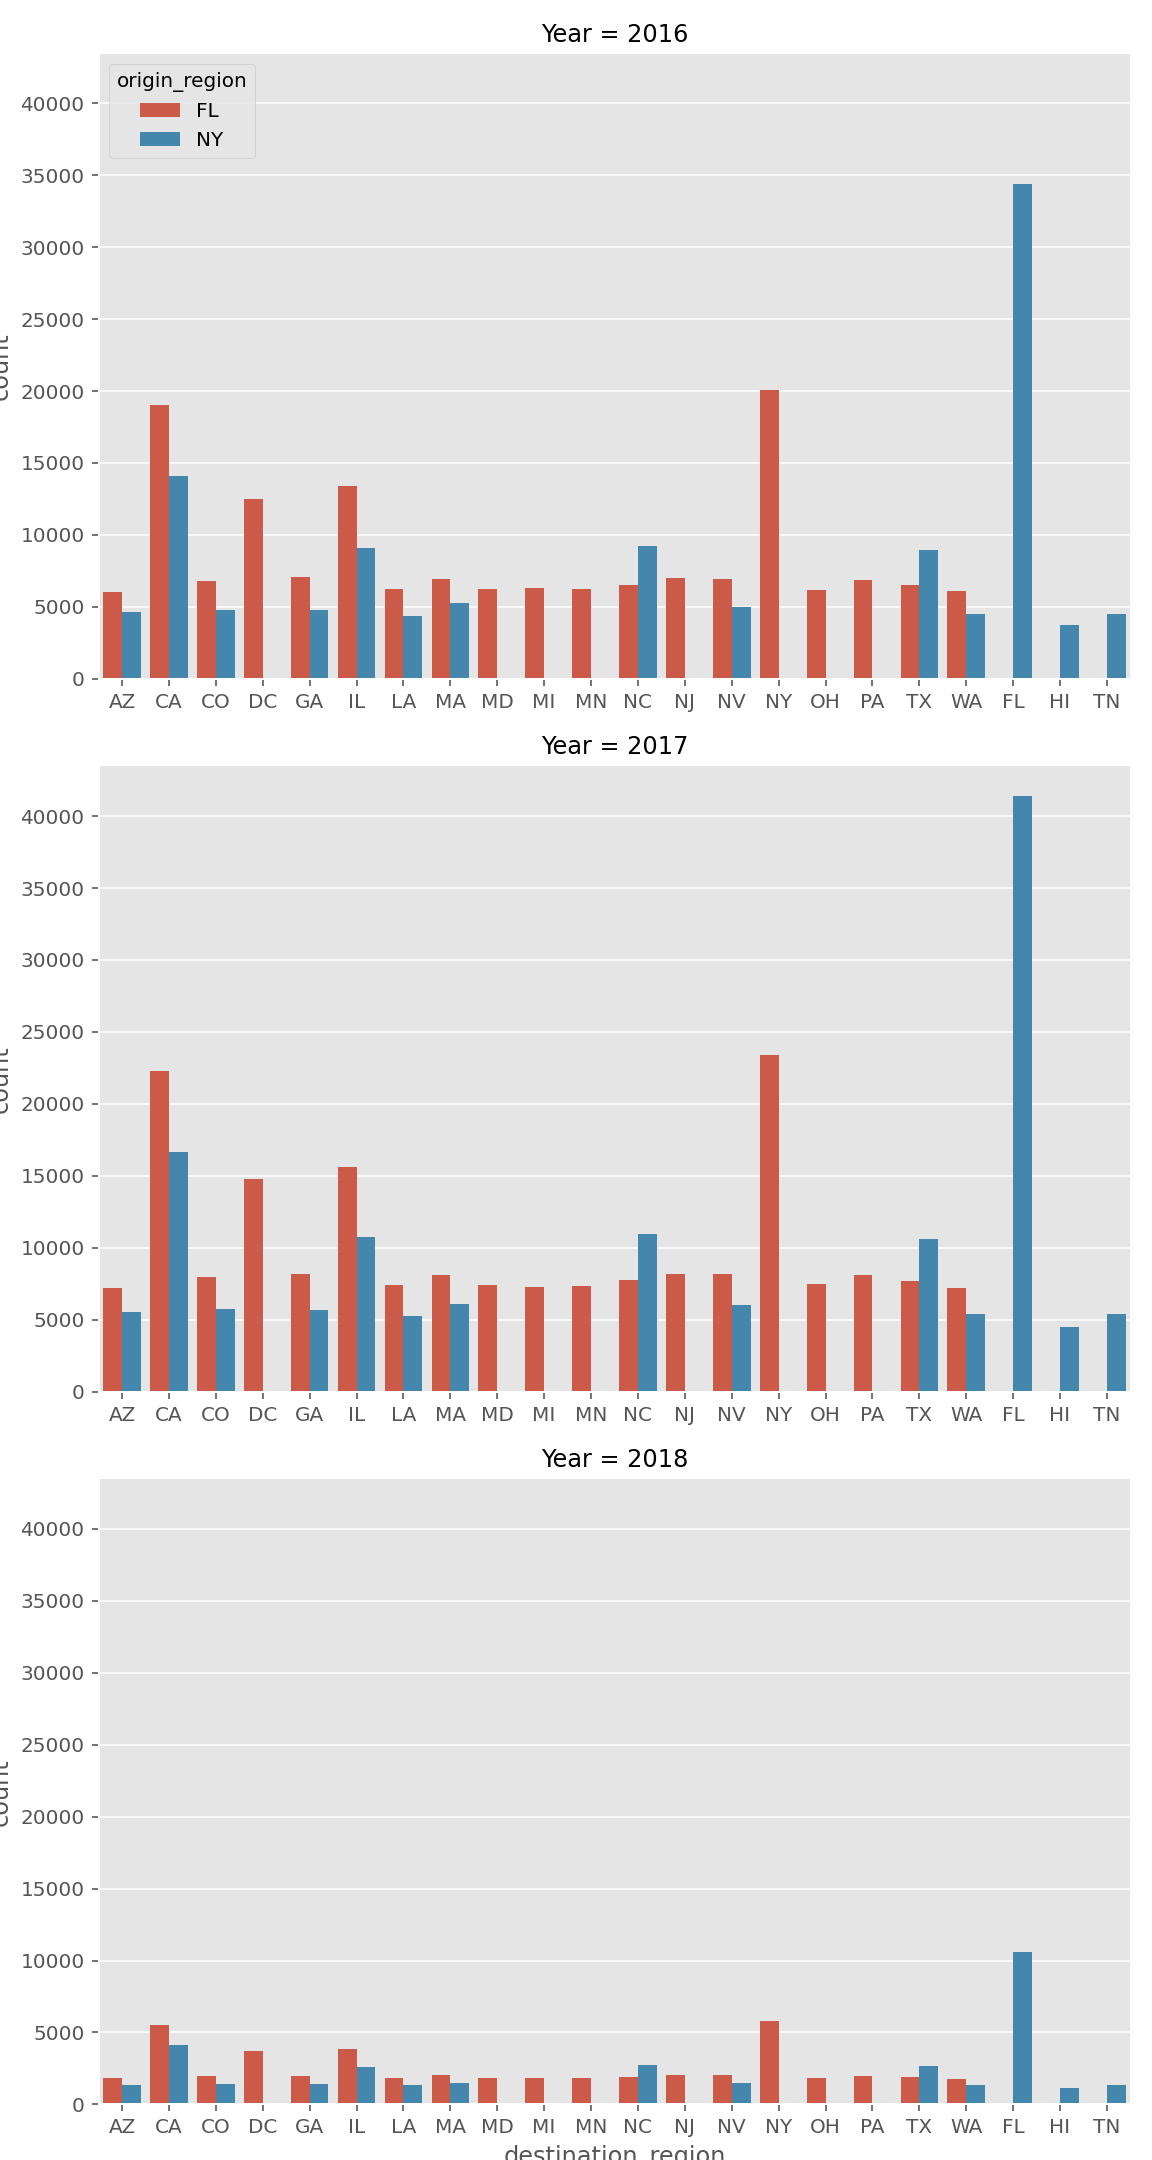

In [42]:
df['count'] = 1
temp  = df.groupby(['origin_region','Year','destination_region'])['count'].count().reset_index()


sns.catplot(x='destination_region',y='count',hue='origin_region',
           row='Year', data=temp, kind='bar', aspect=1.6,
           sharex=False, legend_out=False)
plt.show()

## 4. Reloading data and transforming 

The prior analysis has not revealed much, we will take a different approach. Firstly, we will read the data again

In [43]:
df = pd.read_csv('NY_FL_flight_demand.csv')

In [44]:
"""
Reshaping the dataframe, s.t. demand for each (origin, destination) is computed.\
Furthermore, since the demand is at the airport level. For brevity will be summed up at the state level. 
"""
df_pivot = df.pivot_table(values='flight_demand',index=['search_date'],
               columns=['origin_region','destination_region'], aggfunc='sum' )



origin_region          FL                                                   \
destination_region     AZ     CA     CO     DC     GA     IL     LA     MA   
search_date                                                                  
2016-03-01          12036  68954  23016  34695  25650  38569  11743  38226   
2016-03-02          10944  68028  22975  34853  24794  36657   9641  36418   
2016-03-03          10769  62544  22472  32077  24007  34306   8519  33024   
2016-03-04           9427  55647  19080  28570  21969  29810   8422  28286   
2016-03-05           7356  47156  16129  22882  15228  24322   7016  23528   
...                   ...    ...    ...    ...    ...    ...    ...    ...   
2018-03-27          10108  79916  30290  37958  35659  55193  13925  42396   
2018-03-28           9760  70107  23180  32383  28495  47409  12152  33480   
2018-03-29           9836  62353  23990  29472  26899  44667  11009  30843   
2018-03-30           8663  59179  21835  27766  24310  41826   9831  30047   
2018-03-31           6737  51058  20680  21484  20392  36938   9285  26900   

origin_region                     ...     NY                              \
destination_region     MD     MI  ...     GA     HI     IL     LA     MA   
search_date                       ...                                      
2016-03-01          10321  11748  ...  34800  14404  51048  37178  13287   
2016-03-02          10144  11582  ...  33214  13819  51259  33657  12661   
2016-03-03           9304  11057  ...  30015  13018  46178  29737  11518   
2016-03-04           8479   9605  ...  24300  11360  39156  23519  10850   
2016-03-05           6762   8864  ...  19260  10736  31076  20164   7951   
...                   ...    ...  ...    ...    ...    ...    ...    ...   
2018-03-27          13790  13698  ...  44395  23210  60864  34722  17694   
2018-03-28          11458  11828  ...  32678  16211  55427  30763  15332   
2018-03-29          10529  10913  ...  28528  13527  46619  24108  13740   
2018-03-30          10018  12639  ...  23650  11906  40174  20419  11395   
2018-03-31           9086  10332  ...  20839  11083  34681  18252   9204   

origin_region                                          
destination_region     NC     NV     TN     TX     WA  
search_date                                            
2016-03-01          33331  57911  18034  51693  20292  
2016-03-02          28447  58089  17132  47574  20632  
2016-03-03          27492  51061  14933  45995  17822  
2016-03-04          24039  43296  11616  38340  15356  
2016-03-05          18734  34984   9032  28684  13062  
...                   ...    ...    ...    ...    ...  
2018-03-27          38698  57893  20322  50812  23643  
2018-03-28          31669  50197  17307  43671  19635  
2018-03-29          28397  42990  14499  41517  17089  
2018-03-30          25820  36629  12049  30949  14681  
2018-03-31          20089  30238   9339  27313  12913  

[760 rows x 33 columns]

In [ ]:
from statsmodels.tsa.arima import 